In [135]:
import json as js
import glob
import sys
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction import text 
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns
import numpy as np
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool
import os
from copy import deepcopy
import time
import datetime
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/g/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [136]:
additional_stop_words = ['rt','t','http','u','s','follow','m','dm','y'] ##USE THIS FOR STOP WORDS
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

In [137]:
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in tokenizer.tokenize(doc)]

In [117]:
directory = './data/*'
dictionary = './AFINN-111.txt'

In [118]:
fdict = open(dictionary,'r')
sent_dict = {}
for line in fdict:
    line = line.strip('\n')
    line = line.split('\t')
    sent_dict[line[0]] = int(line[1])

## LOAD TWEET OBJECTS

In [119]:
tweet_objects = []
dirs = glob.glob(directory)
for dr in dirs:
    files = glob.glob(dr+'/*')
    for f in files:
            fin = open(f,'r')
            for line in fin:
                try:
                    dat = js.loads(line)
                    tweet_objects.append(dat)
                except:
                    continue
            fin.close()

In [120]:
months = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07',\
         'Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}

In [121]:
fout = open('tmp.dat','w')
for ln in tweet_objects:
    try:
        entities = ln['entities']
        hashtags = entities['hashtags']
        user_mentions = entities['user_mentions']
    except KeyError:
        continue
    for hashtag in hashtags:
        try:
            hashtag = hashtag['text']
            date = ln['created_at']
            #date = date.split()
            date = str(date)#str(months[date[1]])+str(date[2])+'18_'+str(date[3])
            favorite_count = ln['favorite_count']
            user = ln['user']
            followers = user['followers_count']
            username = user['screen_name']
            location = user['location']
            txt = ln['text'].replace('\n','')
            fout.write(date + '\t' + str(favorite_count)+','+str(followers)+',"'+str(username)+'","'+str(location)+'","'+str(txt)+'"\n')
        except UnicodeEncodeError:#.encode('utf-8')
            continue
fout.close()

In [122]:
df = pd.read_csv('tmp.dat',error_bad_lines=False,header=None,names=\
                 ['date','followers','username','location','tweet'],\
                 delimiter=',',index_col=False)#,encoding='utf-8'
df.shape[0]
df.drop_duplicates(inplace=True)

In [123]:
rm_duplicates = True
if rm_duplicates == False:
    df['rt'] = df['tweet'].str.split(':', expand=True).ix[:,0]
    df.drop_duplicates(subset=['rt'], keep='first',inplace=True)
    df.rt.head()
    df.shape[0]

In [124]:
df.shape[0]

1689

In [125]:
df.head(25)

,date,followers,username,location,tweet
0,Fri Aug 10 08:07:44 +0000 2018\t0,7,Vigoursoftinc,"Pune, India",The 30 Technologies Of The Next Decade#AI #Art...
7,Fri Aug 10 13:48:26 +0000 2018\t0,11050,ristori20,Brussels,RT @esa: Getting smart in space - an overview ...
9,Mon Aug 13 01:56:19 +0000 2018\t0,259,SanjayNursing,"Manchester, England",RT @IainLJBrown: Career in Data Science catche...
15,Sat Aug 11 00:58:07 +0000 2018\t0,1309,Nicolaie31,"Sfântu Gheorghe, România",RT @MHiesboeck: This #robot can #fly a @Boeing...
29,Sat Aug 11 07:26:45 +0000 2018\t0,23480,SStavrinoudakis,"Athens, Greece",RT @tala201677: The General Is a #Robot: #Arti...
31,Sat Aug 11 13:06:00 +0000 2018\t0,244,KickstartNews,None,RT @afigueiredo: Using machine learning to unl...
34,Sat Aug 11 22:00:02 +0000 2018\t0,766,cbunton,"San Jose, CA",Here's some food for thought. Our #NVIDIAJetso...
36,Sun Aug 12 14:29:18 +0000 2018\t0,3376,StuartSimon,Venezuela,RT @kashthefuturist: Usain Bolt's winning stra...
42,Sun Aug 12 18:58:39 +0000 2018\t0,4070,MClarkSEO,"Nashville, Tennessee",RT @MikeQuindazzi: #deeplearning that learns l...
57,Sun Aug 12 19:23:46 +0000 2018\t0,2515,machinelearn_d,The Earth,RT @BigBetAnalytics: Applications of #Artifici...


In [126]:
dates = list(df.date)
cleanDates = []
favs = []
ct = 0
for date in dates:
    date = date.split('\t')
    try:
      ts = time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(date[0],'%a %b %d %H:%M:%S +0000 %Y'))
      favs.append(int(date[1]))
      cleanDates.append(ts)
      ct+=1
    except:
      cleanDates.append(np.NaN)
      favs.append(0)
print(ct)
favs.reverse()
cleanDates.reverse()

1689


In [127]:
print (len(cleanDates))
se = pd.Series(cleanDates)
df.date = se.values

1689


In [128]:
'''
*** Tweets often use popular hashtags with unrelated topics.
*** Certain words can be used in order to filter such tweets.
*** Enter these words below in the bad_terms list.
'''
bad_terms = ['cock','ManiKENniMonica','nudes']
for i in range(len(bad_terms)):
    df.bad = df['tweet'].str.lower().str.contains(bad_terms[i].lower())
    df = df[df.bad == False]

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [129]:
df.shape[0]

1688

## COUNTING HASHTAGS AND CO-OCCURANCE OF HASHTAGS

In [130]:
tweets = list(df.tweet)

In [131]:
hashtags = ['#deeplearning','#machinelearning','#reinforcementlearning','#artificialintelligence']
for i, tag in enumerate(hashtags): hashtags[i] = tag.lower() 
counts = [0 for i in range(len(hashtags))]
for tweet in tweets:
    tweet = tweet.lower()
    for i, tag in enumerate(hashtags):
        if tag in tweet:
            counts[i] += 1
for i, tag in enumerate(hashtags):
    print(tag.upper()+':   '+str(counts[i]))

#DEEPLEARNING:   419
#MACHINELEARNING:   1061
#REINFORCEMENTLEARNING:   4
#ARTIFICIALINTELLIGENCE:   592


In [132]:
tcounts = deepcopy(counts)

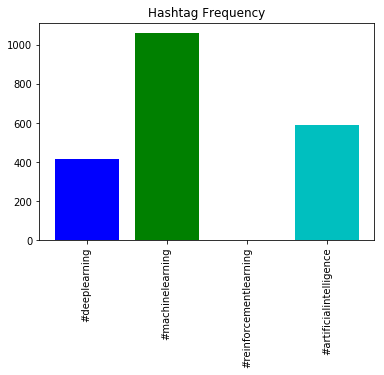

In [133]:
plt.bar(hashtags,counts,color=['b','g','r','c','m','k','y'])
plt.xticks(rotation='vertical')
plt.title('Hashtag Frequency')
plt.savefig('hashtag_frequency.png')
plt.show()

## TOP HASHTAGS

In [67]:
topHashtags = {}
for tweet in tweets:
    tweet = tweet.lower()
    tweet = tweet.split(' ')
    for word in tweet:
        if len(word) == 0:
            continue
        if word[0] == '#':
            try:
                topHashtags[word] += 1
            except:
                topHashtags[word] = 1
sorted_by_value = sorted(topHashtags.items(), key=lambda kv: kv[1])
#print(sorted_by_value)

In [68]:
def plotNhashtags(d,n):
    d = dict(d)
    dkeys = [d.keys()]
    dkeys = list(dkeys[0])
    dvals = [d.values()]
    dvals = list(dvals[0])
    #print(list(dkeys[0]))
    print (dvals[-n:])
    plt.bar(dkeys[-n:],dvals[-n:],color=['r','g','c','m','b','k'])
    plt.xticks(rotation='vertical')
    plt.show()

[627, 898, 1003, 1593, 1762, 2363, 3240, 5145, 6188, 8425]


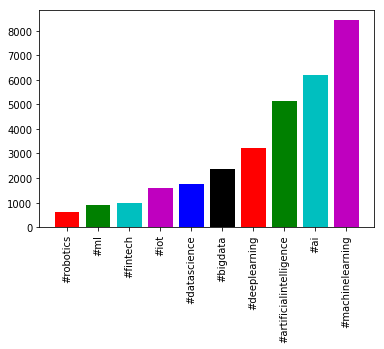

In [71]:
NUMBER_OF_TOP_HASHTAGS = 10
plotNhashtags(sorted_by_value,NUMBER_OF_TOP_HASHTAGS)

## SORT BY DATE

In [72]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date',ascending=True,inplace=True)
df.head(25)

,date,followers,username,location,tweet
4383,2018-08-08 21:49:09,188,CGRIIorg,Global,An interesting proposition from #Google. #Arti...
5969,2018-08-08 21:55:29,333,Vish_Kanumilli,"England, United Kingdom",RT @IainLJBrown: 92% Of AI Leaders Now Trainin...
4962,2018-08-08 22:04:47,9753,ProcurementPros,"Pittsburgh, PA",RT @mvollmer1: Artificial intelligence and Mac...
6382,2018-08-08 22:05:44,29,nomiiguruchiku,"Tukwila, WA",Facebook is racing to build Africa’s internet ...
4650,2018-08-08 22:08:27,4686,machinelearn_d,The Earth,RT @danielcfng: Amr @Awadallah Founder and #CT...
4646,2018-08-08 22:15:01,1946,D3pak,Internet,"Amazon CEO Jeff Bezos says AI, ML, robots won..."
4634,2018-08-08 22:34:06,54379,pierrepinna,"Marseille, France",RT @andi_staub: Quick guide to understand the ...
4850,2018-08-08 22:35:07,29,ReliableIOC,None,Inspecting Decision Trees in H2O https://t.co/...
6547,2018-08-08 23:19:01,3840,iot_base,"Washington, DC",RT @WiproDigital: Here are the top 10 #AI tren...
6777,2018-08-08 23:19:07,1634,effendi23_,"Jakarta, Indonesia",RT @lawtest_ee: What do you know about office ...


In [76]:
ad_rollout = datetime.datetime(2018,12,31,23,59)
before = df[df.date < ad_rollout]
print(before.shape[0])
after = df[df.date > ad_rollout]
print(after.shape[0])
btweets = list(before.tweet)
atweets = list(after.tweet)

15632
1784


In [77]:
for i, tag in enumerate(hashtags): hashtags[i] = tag.lower() 
bcounts = [0 for i in range(len(hashtags))]
for tweet in btweets:
    tweet = tweet.lower()
    for i, tag in enumerate(hashtags):
        if tag in tweet:
            bcounts[i] += 1
for i, tag in enumerate(hashtags):
    print(tag.upper()+':   '+str(bcounts[i]))

#DEEPLEARNING:   3590
#MACHINELEARNING:   9073
#REINFORCEMENTLEARNING:   53
#ARTIFICIALINTELLIGENCE:   6154


In [78]:
for i, tag in enumerate(hashtags): hashtags[i] = tag.lower() 
acounts = [0 for i in range(len(hashtags))]
for tweet in atweets:
    tweet = tweet.lower()
    for i, tag in enumerate(hashtags):
        if tag in tweet:
            acounts[i] += 1
for i, tag in enumerate(hashtags):
    print(tag.upper()+':   '+str(acounts[i]))

#DEEPLEARNING:   392
#MACHINELEARNING:   1083
#REINFORCEMENTLEARNING:   8
#ARTIFICIALINTELLIGENCE:   653


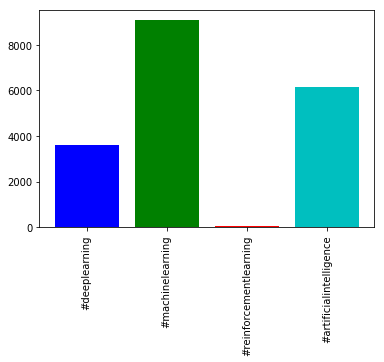

In [79]:
plt.bar(hashtags,bcounts,color=['b','g','r','c','m','k','y'])
plt.xticks(rotation='vertical')
plt.show()

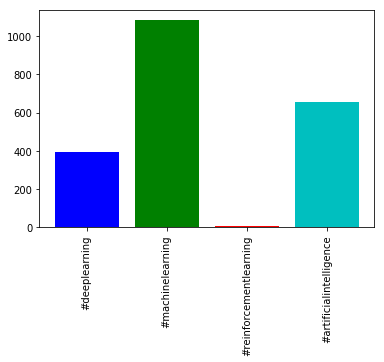

In [80]:
plt.bar(hashtags,acounts,color=['b','g','r','c','m','k','y'])
plt.xticks(rotation='vertical')
plt.show()

# Sentiment analysis using dictionary

In [104]:
tweet_sent = []
for tweet in tweets:
    tweet = tweet.lower()
    tweet = tweet.split(' ')
    sent = 0
    for word in tweet:
        word = word.strip('#')
        try:
            sent += sent_dict[word]
        except:
            pass
    tweet_sent.append(sent)

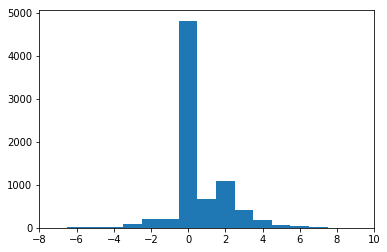

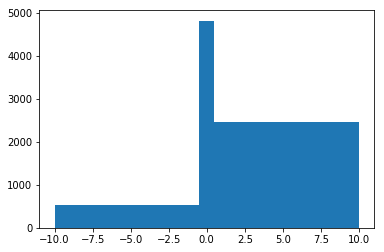

In [105]:
plt.hist(tweet_sent,bins=[-7.5,-6.5,-5.5,-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5])#,
        #color=['r','r','r','r','r','r','r','k','g','g','g','g','g','g','g'])
plt.xlim(-8,10)
plt.show()
plt.hist(tweet_sent,bins=[-10,-0.5,0.5,10])
plt.xlim(-11,11)
plt.show()

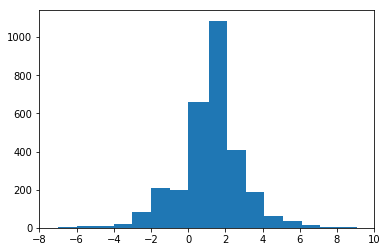

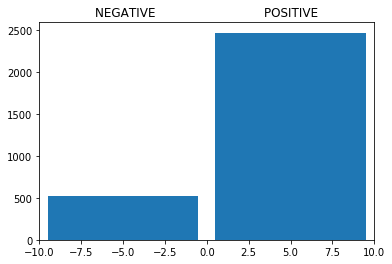

In [106]:
tweet_sent_alt = []
for tweet in tweet_sent:
    if tweet == 0:
        pass
    else:
        tweet_sent_alt.append(tweet)
plt.hist(tweet_sent_alt,bins=[-7,-6,-5,-4,-3,-2,-1,0,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1])#,
        #color=['r','r','r','r','r','r','r','k','g','g','g','g','g','g','g'])
plt.xlim(-8,10)
plt.show()
plt.hist(tweet_sent_alt,bins=[-10,0,10],rwidth=0.9)
plt.xlim(-10,10) 
plt.title('NEGATIVE                            POSITIVE')
plt.show()

In [107]:
hashtags = ['#deeplearning','#machinelearning','#reinforcementlearning','#artificialintelligence']
for i, tag in enumerate(hashtags): hashtags[i] = tag.lower() 
counts = [0 for i in range(len(hashtags))]
tag_sents = {}
tag_sent_list = {}
tag_sent_values = {}
for tag in hashtags:
    tag = tag.lower()
    tag_sents[tag] = 0
    tag_sent_list[tag] = []
    tag_sent_values[tag] = 0
#tweets_ = tweets[:100]
for tweet in tweets:
    tweet = tweet.lower()
    tweet = tweet.split(' ')
    sent = 0
    for word in tweet:
        #print (word)
        word = word.strip('#')
        try:
            sent += sent_dict[word]
        except:
            pass
    for i, tag in enumerate(hashtags):
        tag = tag.lower()
        if tag in tweet:
            try:
                tag_sents[tag] += sent
                tag_sent_list[tag].append(sent)
            except:
                pass
tag_sents_ = deepcopy(tag_sents)
for i, key in enumerate(tag_sents_.keys()):
    tag_sents_[key] = tag_sents_[key]/tcounts[i]
print (tag_sents_)

{'#deeplearning': 0.4843630816170862, '#machinelearning': 0.4733782841199721, '#reinforcementlearning': 0.9629629629629629, '#artificialintelligence': 0.4115776081424936}


### Average sentiment scores per hashtag

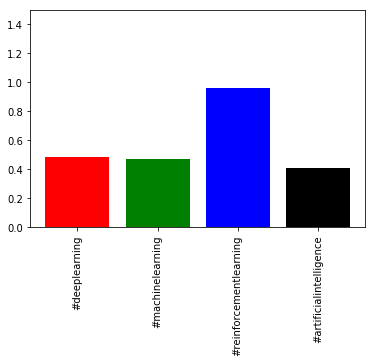

In [109]:
plt.bar(tag_sents_.keys(),tag_sents_.values(),color=['r','g','b','k'])
plt.xticks(rotation='vertical')
plt.ylim(0,1.5)
plt.show()

### Total positive/negative tweets per hashtag

{'#deeplearning': 732, '#machinelearning': 2075, '#reinforcementlearning': 14, '#artificialintelligence': 1157}
6068


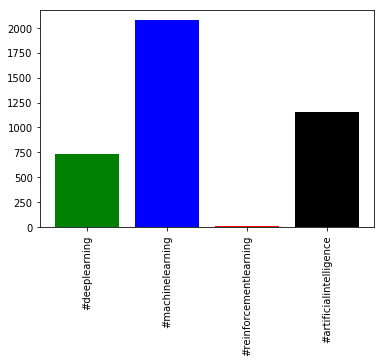

In [87]:
ct = 0
for i, tag in enumerate(tag_sent_list.keys()):
    #print(len(tag_sent_list[tag]))
    for tweet in tag_sent_list[tag]:
        if tweet > 0:
            tag_sent_values[tag] += 1
            ct += 1
        elif tweet < 0:
            tag_sent_values[tag] -= 1
            ct += 1
print (tag_sent_values)
print (ct)
plt.bar(tag_sent_values.keys(),tag_sent_values.values(),color=['g','b','r','k'])
plt.xticks(rotation='vertical')
plt.show()

### #deeplearning - no neutral tweets

In [88]:
justdoit = deepcopy(tag_sent_list['#deeplearning'])
justdoit_alt = []
for tweet in justdoit:
    if tweet == 0:
        pass
    else:
        justdoit_alt.append(tweet)
#print(justdoit_alt)

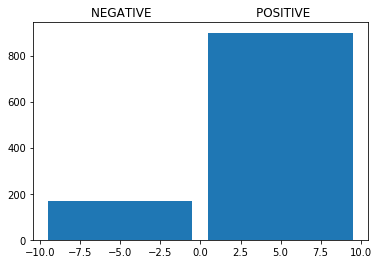

In [89]:
plt.hist(justdoit_alt,bins=[-10,0,10],rwidth=0.9)
plt.title('NEGATIVE                           POSITIVE')
plt.show()

### #machinelearning - no neutral tweets

In [90]:
nike = deepcopy(tag_sent_list['#machinelearning'])
nike_alt = []
for tweet in nike:
    if tweet == 0:
        pass
    else:
        nike_alt.append(tweet)

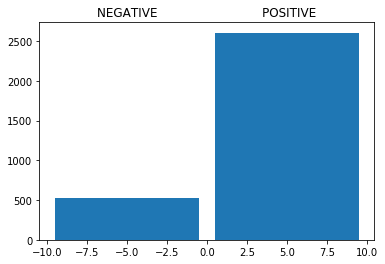

In [91]:
plt.hist(nike_alt,bins=[-10,0,10],rwidth=0.9)
plt.title('NEGATIVE                           POSITIVE')
plt.show()

### #artificialintelligence - no neutral tweets

In [92]:
atnike = deepcopy(tag_sent_list['#artificialintelligence'])
atnike_alt = []
for tweet in atnike:
    if tweet == 0:
        pass
    else:
        atnike_alt.append(tweet)

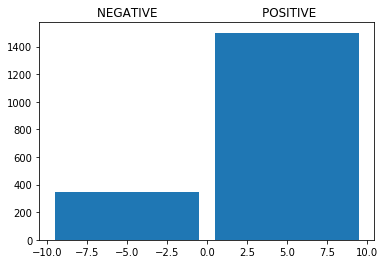

In [93]:
plt.hist(atnike_alt,bins=[-10,0,10],rwidth=0.9)
plt.title('NEGATIVE                           POSITIVE')
plt.show()

In [94]:
ad_rollout = datetime.datetime(2018,9,2,23,59)
one_week_after = datetime.datetime(2018,9,12,23,59)
before = df[df.date < ad_rollout]
after = df[df.date > ad_rollout]
btweets = list(before.tweet)
right_after = after[after.date < one_week_after]
week_past = after[after.date > one_week_after]
ratweets = list(right_after.tweet)
wptweets = list(week_past.tweet)
print(len(ratweets))
print(len(wptweets))

1180
13450


### Removes retweets

In [110]:
rm_duplicates = False
if rm_duplicates == False:
    df['rt'] = df['tweet'].str.split(':', expand=True).ix[:,0]
    df.drop_duplicates(subset=['rt'], keep='first',inplace=True)
    df.rt.head()
    df.shape[0]

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


In [111]:
tweets = list(df.tweet)
hashtags = ['#deeplearning','#machinelearning','#reinforcementlearning','#artificialintelligence']
for i, tag in enumerate(hashtags): hashtags[i] = tag.lower() 
counts = [0 for i in range(len(hashtags))]
for tweet in tweets:
    tweet = tweet.lower()
    for i, tag in enumerate(hashtags):
        if tag in tweet:
            counts[i] += 1
for i, tag in enumerate(hashtags):
    print(tag.upper()+':   '+str(counts[i]))
tcounts = deepcopy(counts)

tweet_sent = []
for tweet in tweets:
    tweet = tweet.lower()
    tweet = tweet.split(' ')
    sent = 0
    for word in tweet:
        word = word.strip('#')
        try:
            sent += sent_dict[word]
        except:
            pass
    tweet_sent.append(sent)


hashtags = ['#deeplearning','#machinelearning','#reinforcementlearning','#artificialintelligence']
for i, tag in enumerate(hashtags): hashtags[i] = tag.lower() 
counts = [0 for i in range(len(hashtags))]
tag_sents = {}
tag_sent_list = {}
tag_sent_values = {}
for tag in hashtags:
    tag = tag.lower()
    tag_sents[tag] = 0
    tag_sent_list[tag] = []
    tag_sent_values[tag] = 0
#tweets_ = tweets[:100]
for tweet in tweets:
    tweet = tweet.lower()
    tweet = tweet.split(' ')
    sent = 0
    for word in tweet:
        #print (word)
        word = word.strip('#')
        try:
            sent += sent_dict[word]
        except:
            pass
    for i, tag in enumerate(hashtags):
        tag = tag.lower()
        if tag in tweet:
            try:
                tag_sents[tag] += sent
                tag_sent_list[tag].append(sent)
            except:
                pass
tag_sents_ = deepcopy(tag_sents)
for i, key in enumerate(tag_sents_.keys()):
    tag_sents_[key] = tag_sents_[key]/tcounts[i]
print (tag_sents_)

#DEEPLEARNING:   1311
#MACHINELEARNING:   4301
#REINFORCEMENTLEARNING:   27
#ARTIFICIALINTELLIGENCE:   3144
{'#deeplearning': 0.4843630816170862, '#machinelearning': 0.4733782841199721, '#reinforcementlearning': 0.9629629629629629, '#artificialintelligence': 0.4115776081424936}


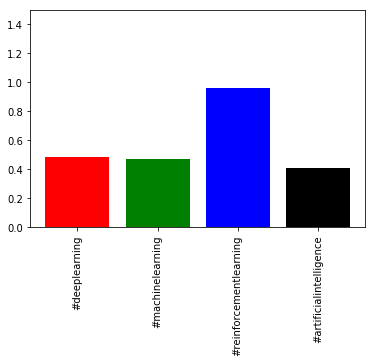

In [112]:
plt.bar(tag_sents_.keys(),tag_sents_.values(),color=['r','g','b','k'])
plt.xticks(rotation='vertical')
plt.ylim(0,1.5)
plt.show()

{'#deeplearning': 247, '#machinelearning': 902, '#reinforcementlearning': 8, '#artificialintelligence': 574}
2663


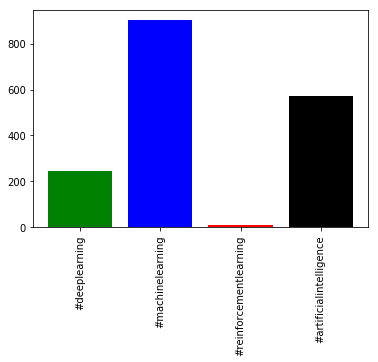

In [113]:
ct = 0
for i, tag in enumerate(tag_sent_list.keys()):
    #print(len(tag_sent_list[tag]))
    for tweet in tag_sent_list[tag]:
        if tweet > 0:
            tag_sent_values[tag] += 1
            ct += 1
        elif tweet < 0:
            tag_sent_values[tag] -= 1
            ct += 1
print (tag_sent_values)
print (ct)
plt.bar(tag_sent_values.keys(),tag_sent_values.values(),color=['g','b','r','k'])
plt.xticks(rotation='vertical')
plt.show()